In [2]:
#!pip install jax
#!pip install -U "jax[cpu]"
#!pip install mat73
#!pip install scikit-learn-extra 
# Comment out the lines above after running them once. 
#!pip install pandas
#!pip install seaborn

# Importing the libraries
import sys
import psutil
import time
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy
from scipy import signal
from scipy.signal import find_peaks
import json
import mat73
import math
import os
import pandas as pd
import seaborn as sns


In [3]:
def compare_sources(list1, list2, tolerance):
    #tolerance = 5
    duplicate_matches = 0

    list1_matches = set()
    list2_matches = set()
    list1_duplicates = set()
    list2_duplicates = set()

    for  spike_idx in list1:
        for spike2_idx in list2:
            #print(f'Cheking: {spike_idx} & {spike2_idx}')
            #print(f'Difference: {abs(spike_idx-spike2_idx)}')

            if  abs(spike_idx-spike2_idx) < tolerance:  
                if spike_idx not in list1_matches and spike2_idx not in list2_matches:
                    
                    # Add the spike pair to the matched spikes
                    list1_matches.add(spike_idx)
                    list2_matches.add(spike2_idx)

                else:
                    # Add the spike pair to the duplicate list
                    list1_duplicates.add(spike_idx)
                    list2_duplicates.add(spike2_idx)

                    # Incriment the duplicate counter
                    duplicate_matches += 1


            if (spike_idx - spike2_idx) < - tolerance:
                #print('There is no way back!')
                break

    list1_duplicates = list1_duplicates - list1_matches
    list2_duplicates = list2_duplicates - list2_matches

    matched_count = len(list1_matches) + len(list2_matches)
    spikes_with_duplicates = len(set(list1_duplicates)) + len(set(list2_duplicates))
    unmatched_count = len(list1) + len(list2) - matched_count - len(list1_duplicates) - len(list2_duplicates)
    rate_of_agreement = (matched_count / (matched_count + unmatched_count + spikes_with_duplicates)) * 100
    print("Start")
    print(matched_count)
    print(unmatched_count)
    print(spikes_with_duplicates)
    print(len(list1))
    print(len(list2))
    print(rate_of_agreement)
    print("\n")

    return matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement

In [4]:
# Fetch the true sources
file_path = '../data/SIMULATION_56_40.mat'
# Create a dictionary from the matlab data file.
data_dict = scipy.io.loadmat(file_path)

# Extract the EMG spike data into a numpy array
MUPulses = np.array(data_dict['MUPulses'][0])
print(MUPulses.shape)
print(MUPulses[40].shape)

(56,)
(1, 719)


In [5]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/output.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
dup_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        sourceB = sourceB["SpikeTrain"]
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))

        matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement = compare_sources(sourceA, sourceB, roa_tolerance)

        roa_matrix.iloc[idxA, idxB] = np.round(rate_of_agreement).astype(int)
        dup_matrix.iloc[idxA, idxB] = spikes_with_duplicates

    loopidx = 1

print(roa_matrix)
print(dup_matrix)

(56, 47)


Start
126
792
0
760
158
13.725490196078432


Start
126
784
0
760
150
13.846153846153847


Start
128
782
0
760
150
14.065934065934066


Start
112
797
0
760
149
12.32123212321232


Start
134
779
0
760
153
14.676889375684556


Start
234
833
0
760
307
21.930646672914715


Start
120
790
0
760
150
13.186813186813188


Start
718
970
0
760
928
42.53554502369668


Start
122
784
0
760
146
13.46578366445916


Start
112
802
0
760
154
12.25382932166302


Start
124
788
0
760
152
13.596491228070176


Start
104
804
0
760
148
11.45374449339207


Start
122
795
0
760
157
13.304252998909488


Start
116
792
0
760
148
12.77533039647577


Start
110
788
0
760
138
12.24944320712695


Start
122
788
0
760
150
13.406593406593407


Start
264
828
0
760
332
24.175824175824175


Start
118
805
0
760
163
12.784398699891659


Start
140
786
0
760
166
15.118790496760258


Start
130
778
0
760
148
14.317180616740089


Start
144
788
0
760
172
15.450643776824036


Start
108
798
0
760
146
11.920529801324504


Start
130
782
0
7

KeyboardInterrupt: 

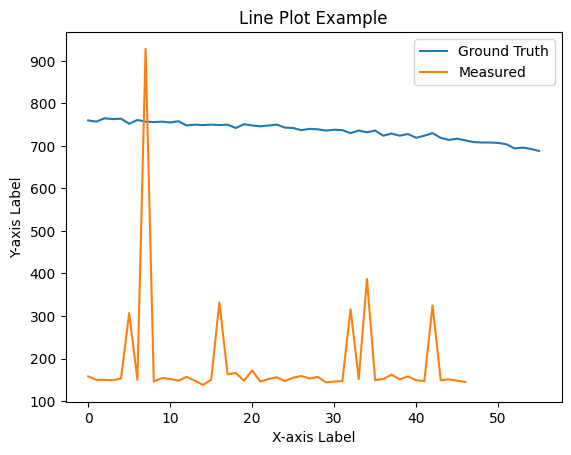

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the first line
sns.lineplot(spikeCountTrue, label='Ground Truth', ax=ax)

# Plot the second line
sns.lineplot(spikeCountCalc, label='Measured', ax=ax)

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Line Plot Example')

# Show the legend
ax.legend()

# Display the plot
plt.show()

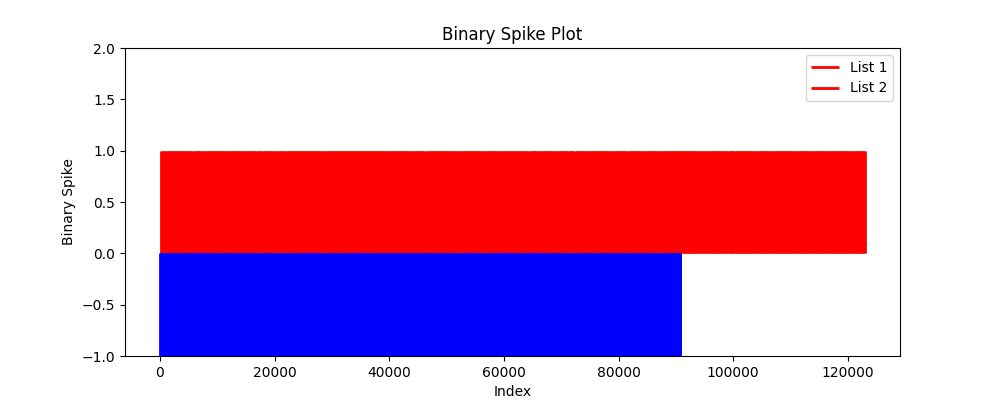

46
24


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[6][0]
list2 = MUPulsesB[7]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()
print(roa_matrix[7][6])
print(roa_matrix[5][1])

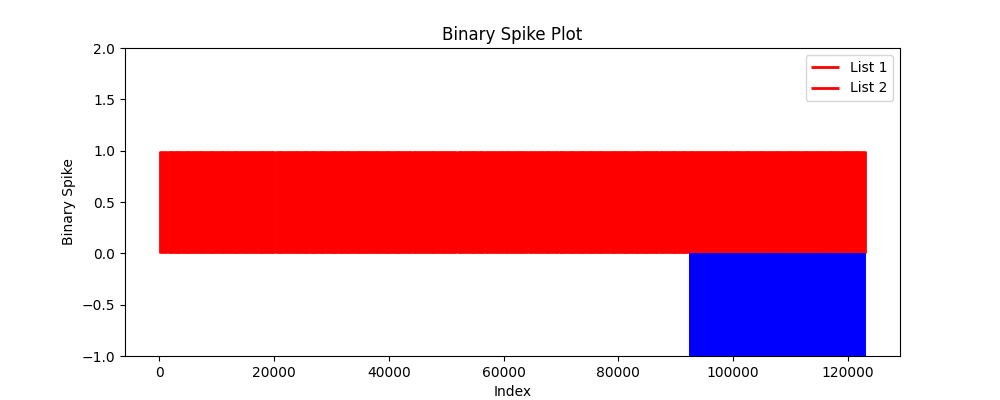

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[6][0]
list2 = MUPulsesB[5]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

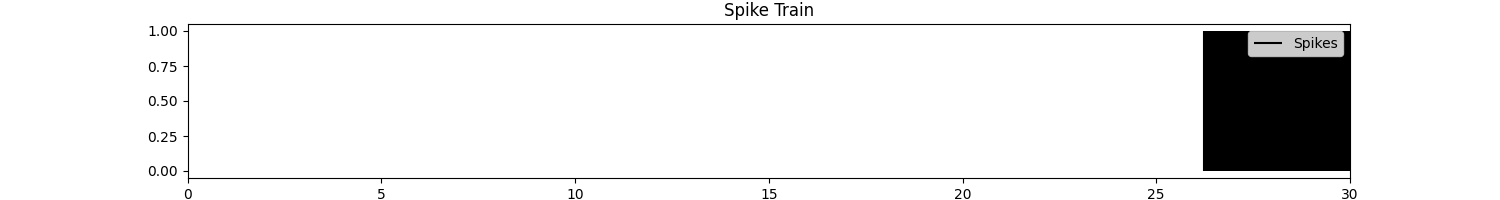

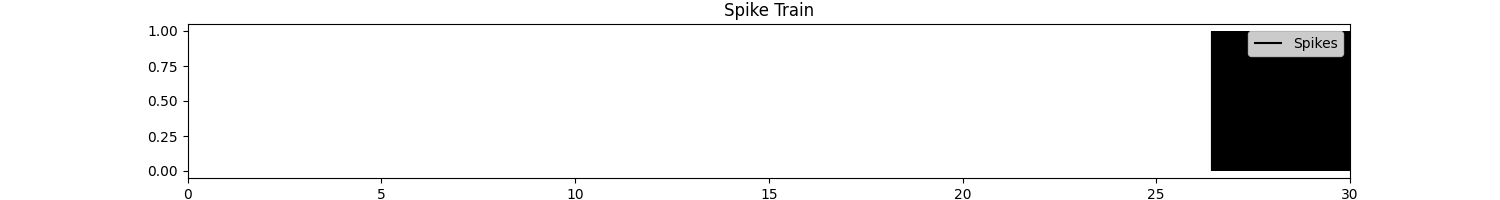

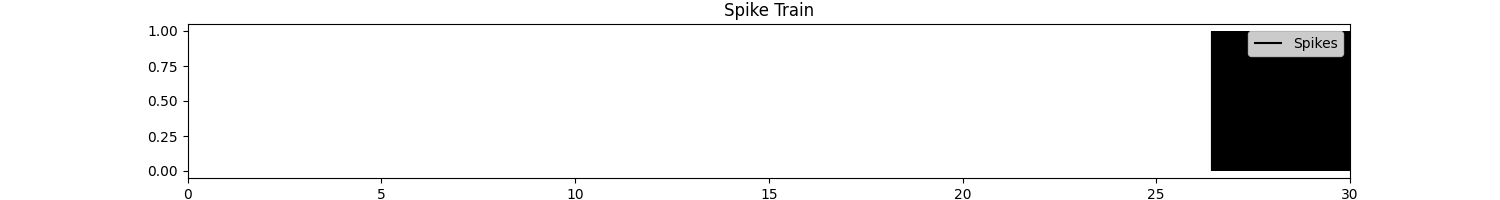

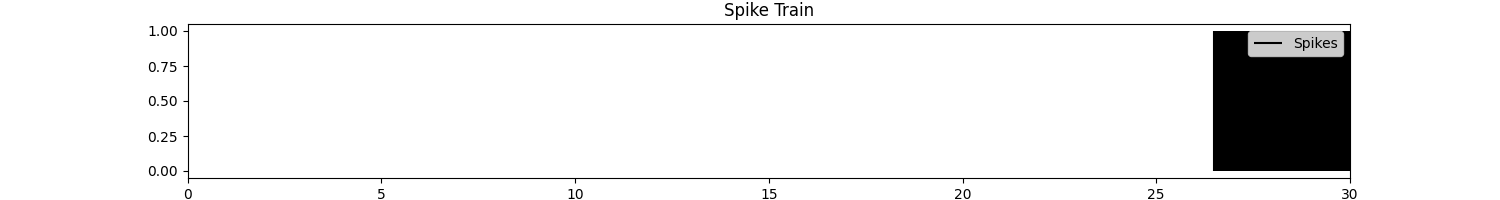

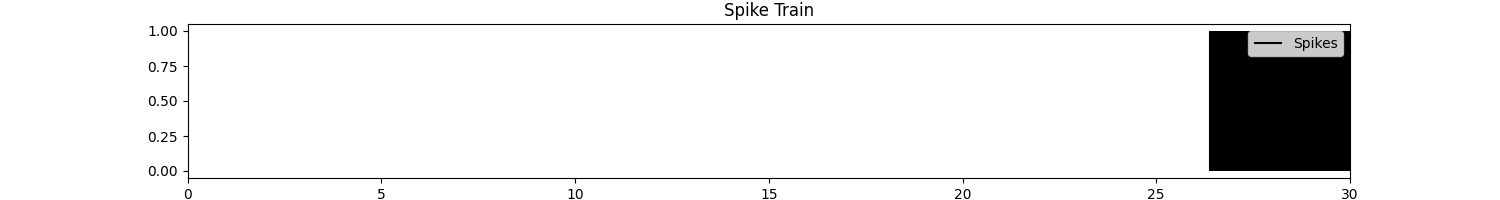

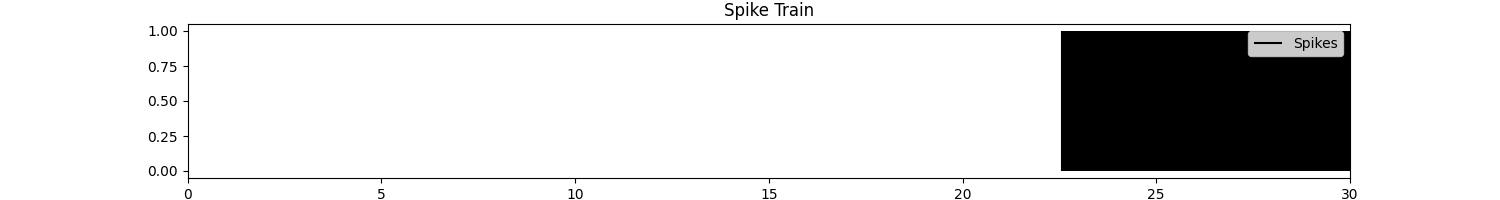

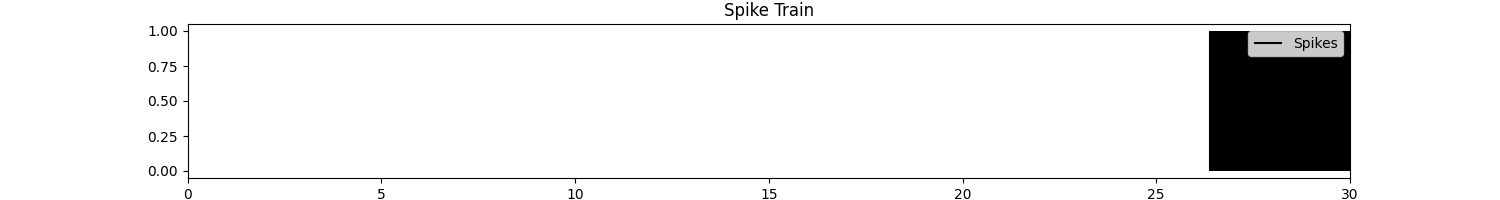

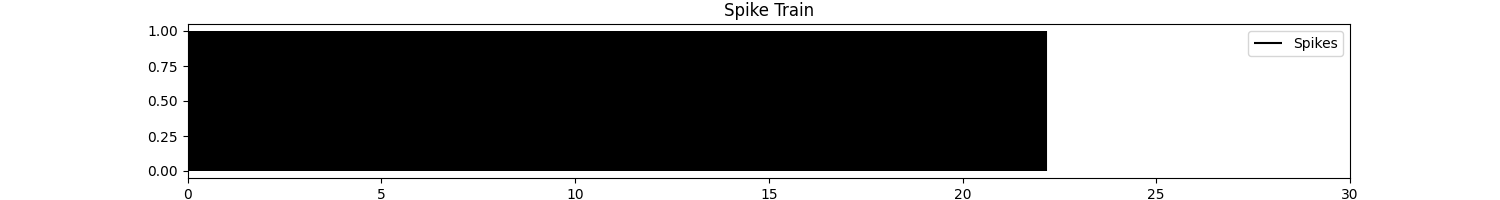

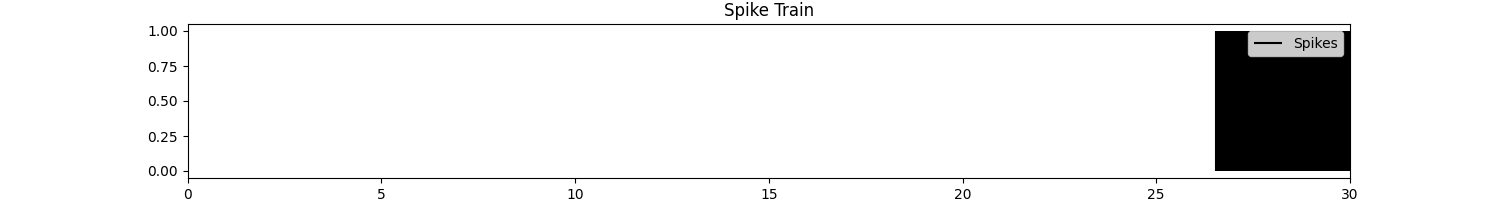

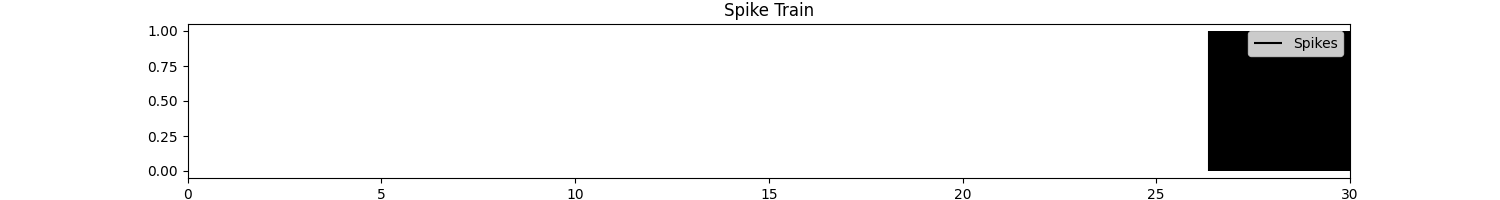

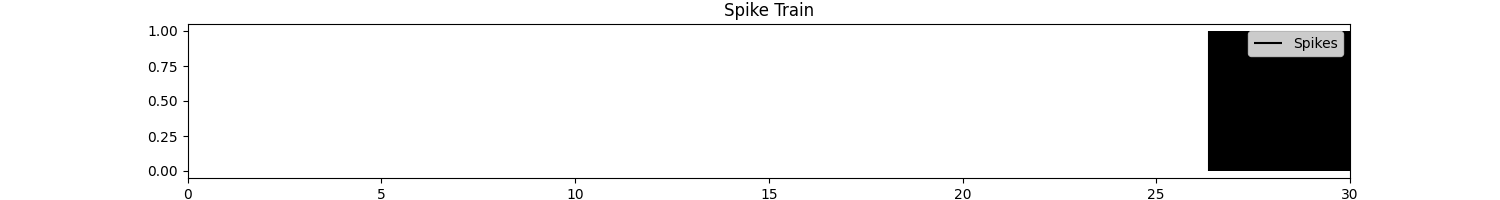

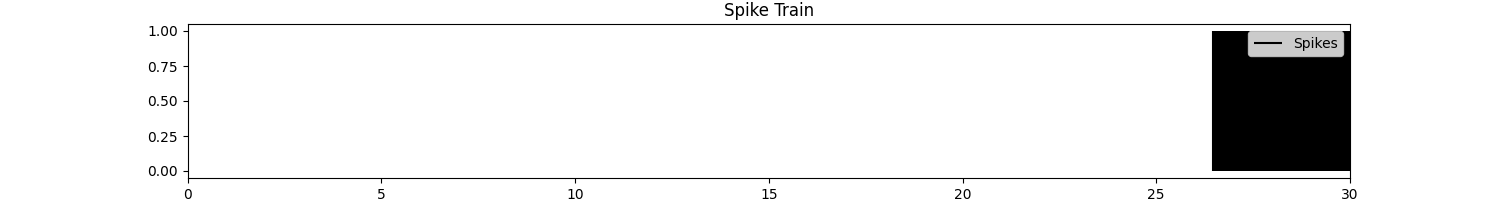

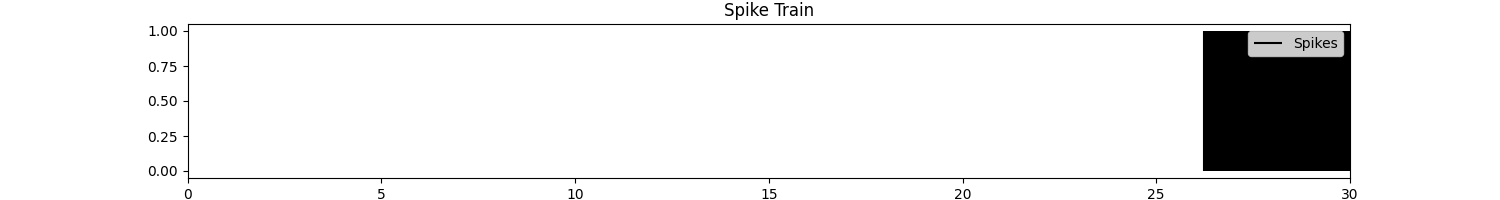

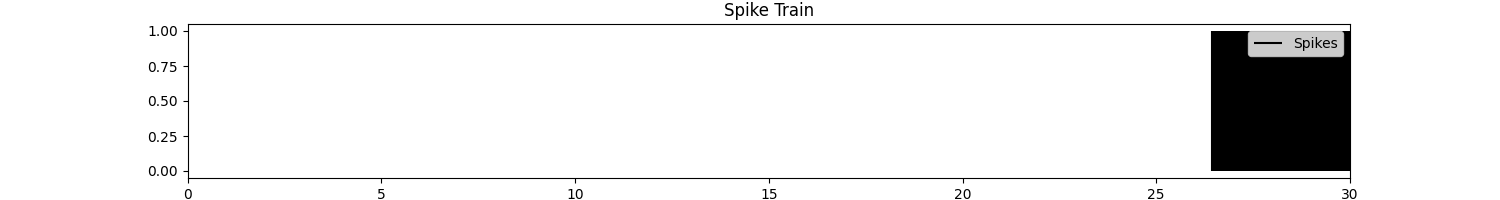

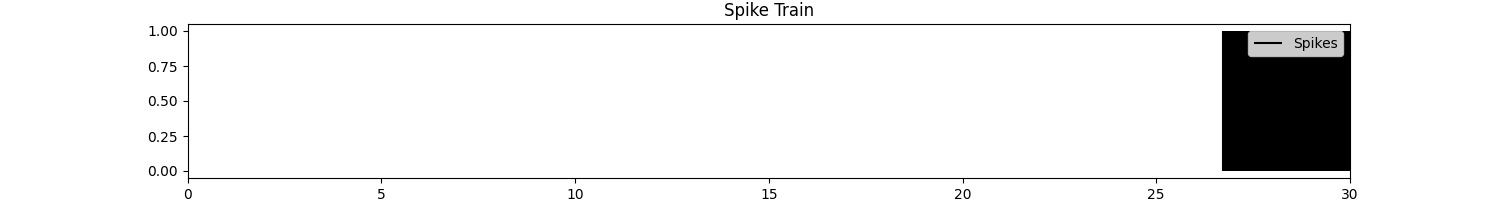

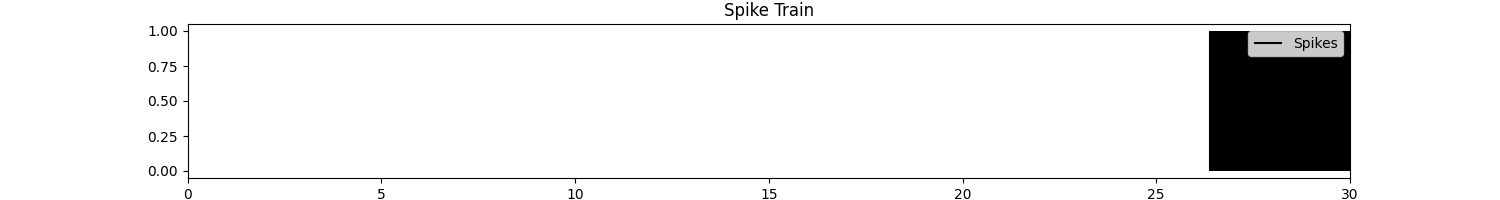

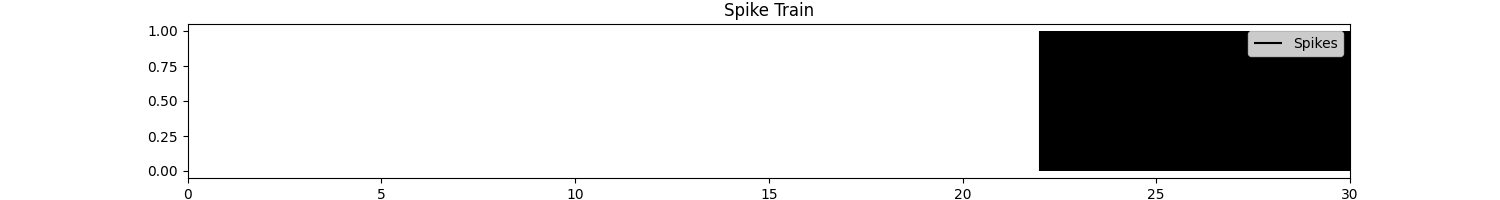

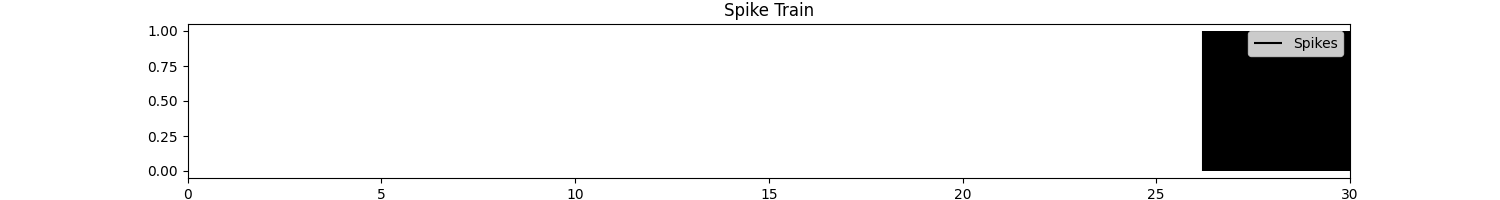

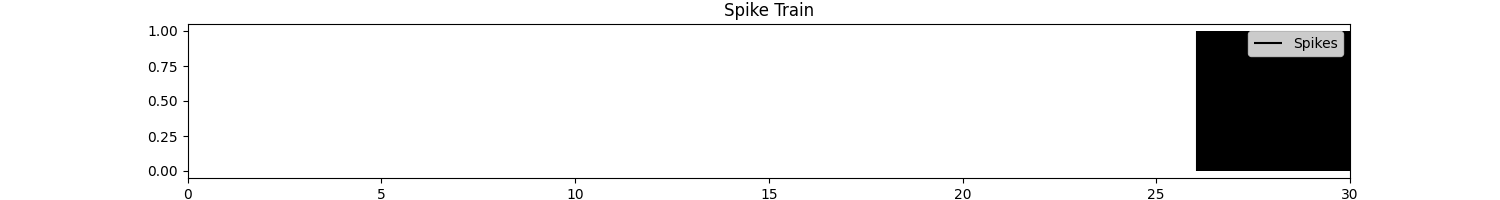

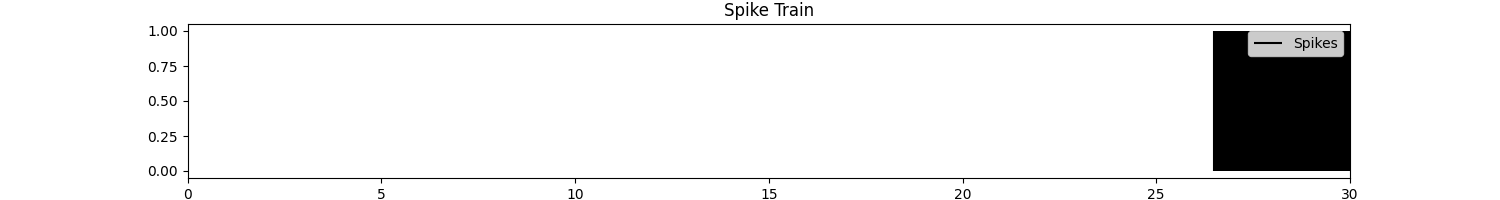

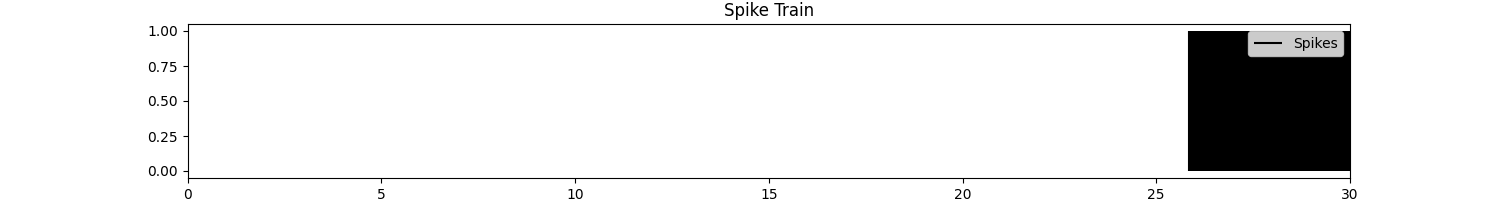

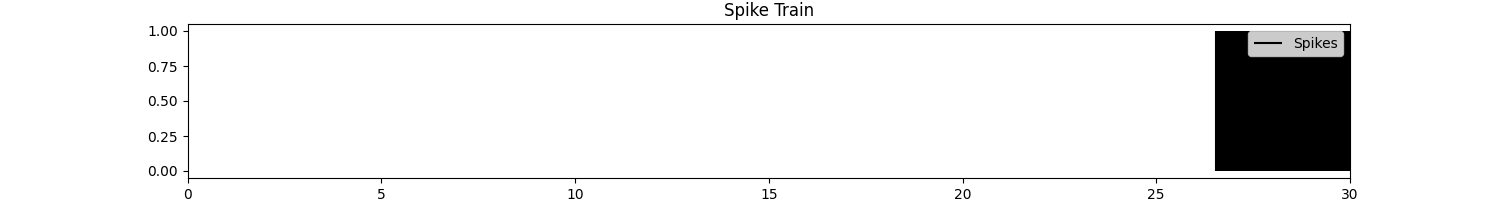

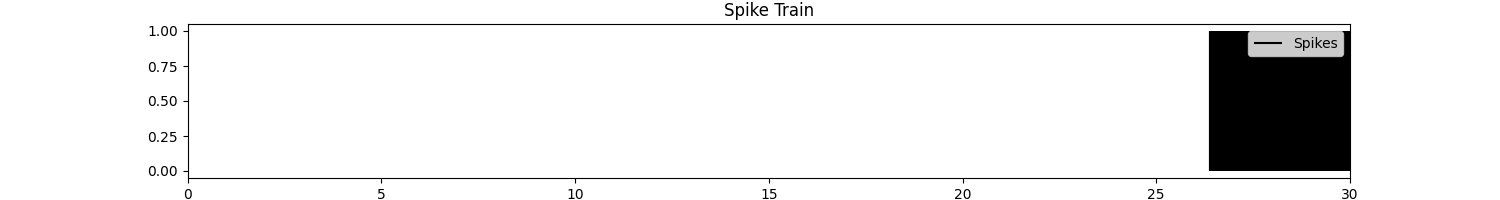

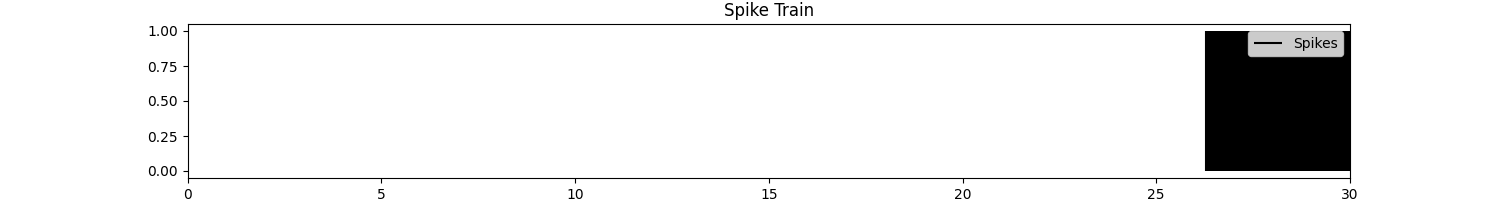

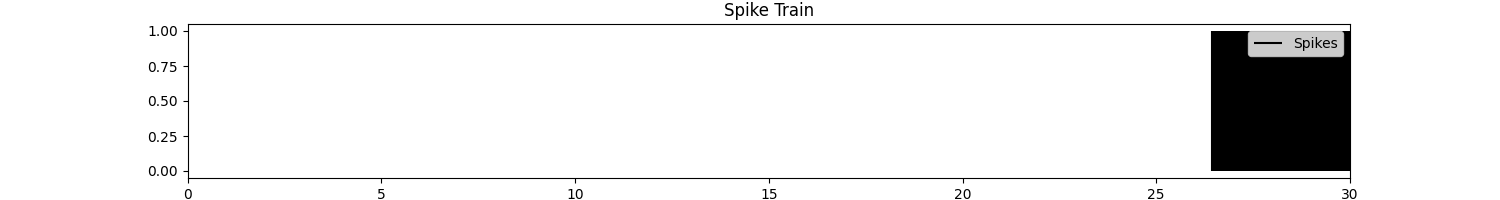

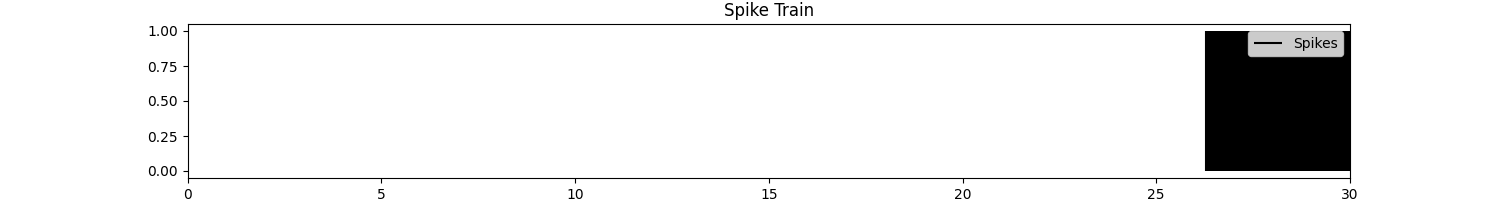

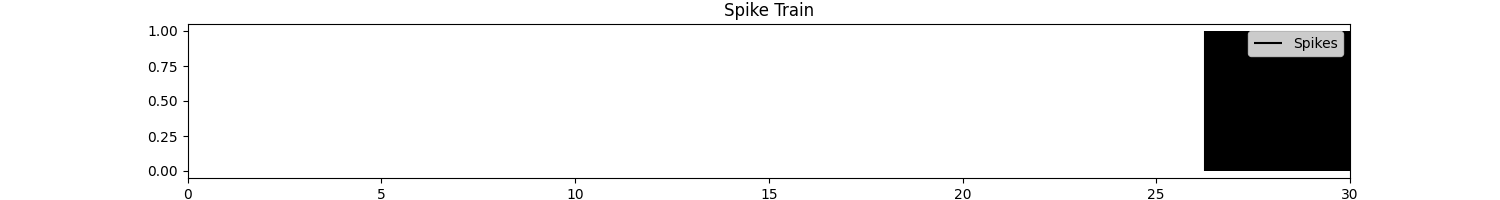

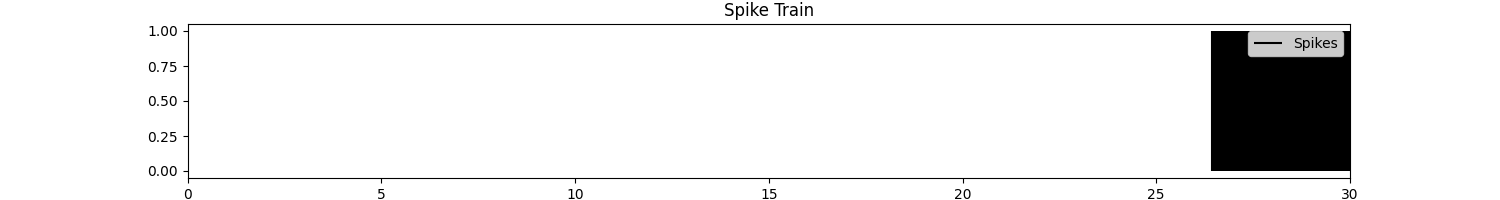

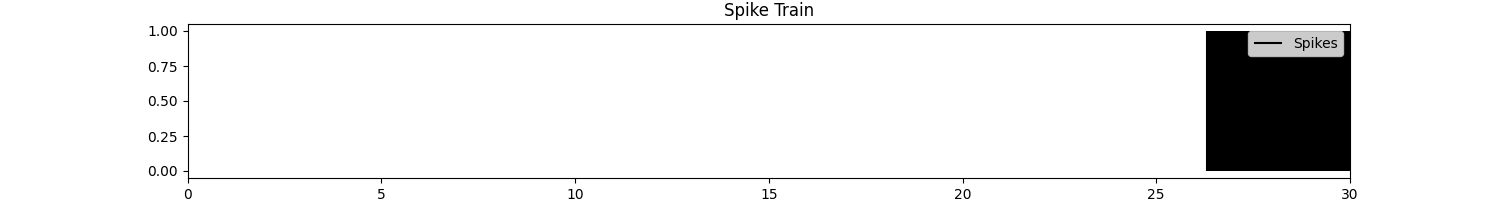

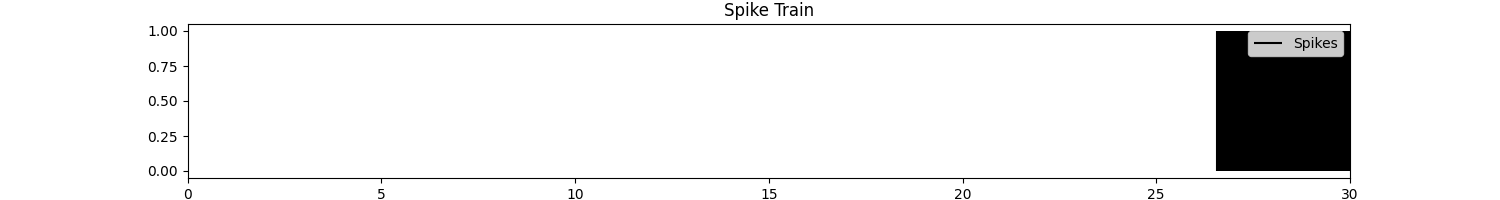

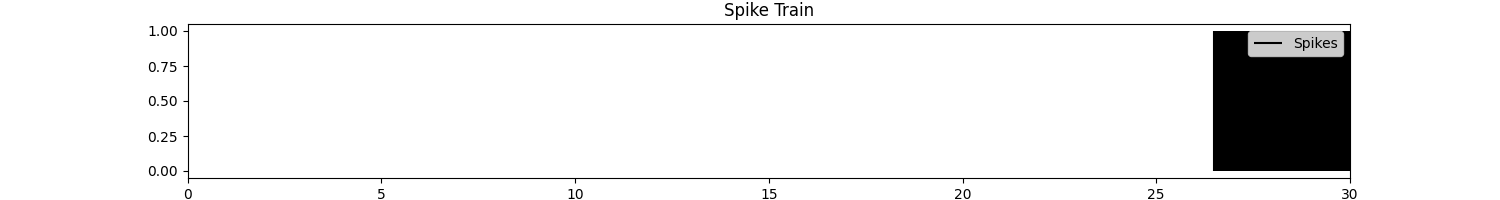

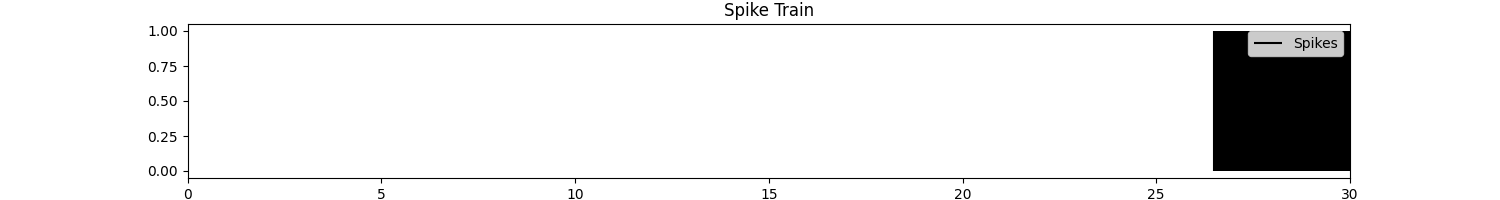

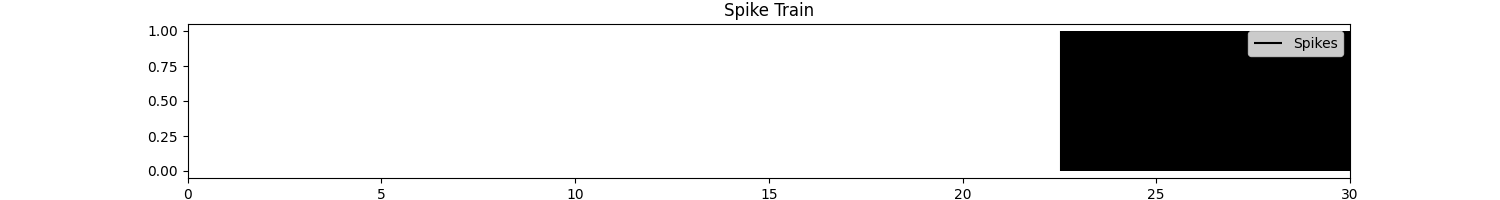

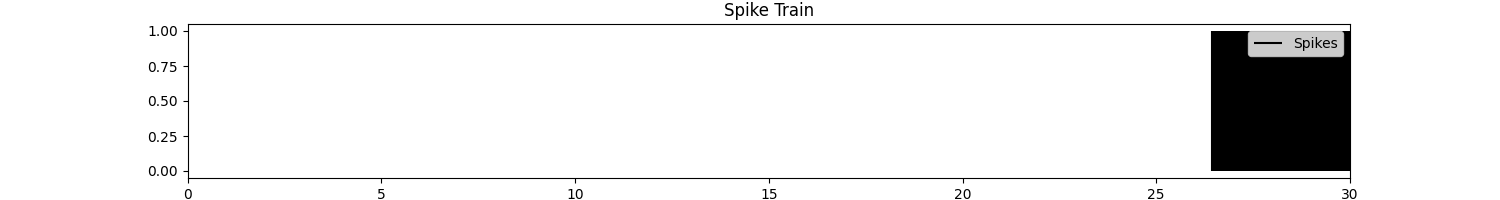

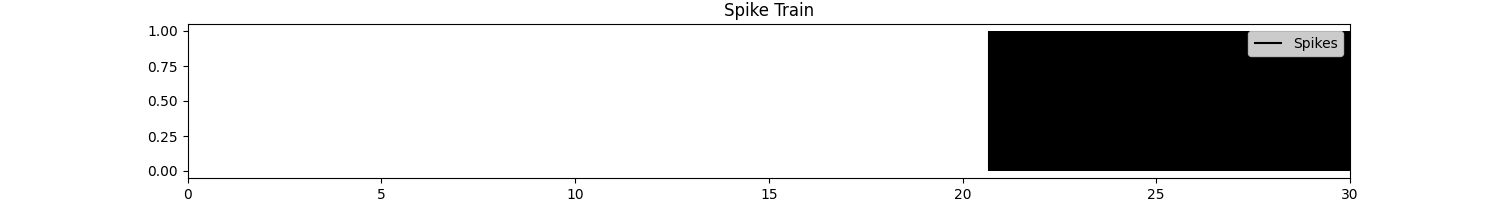

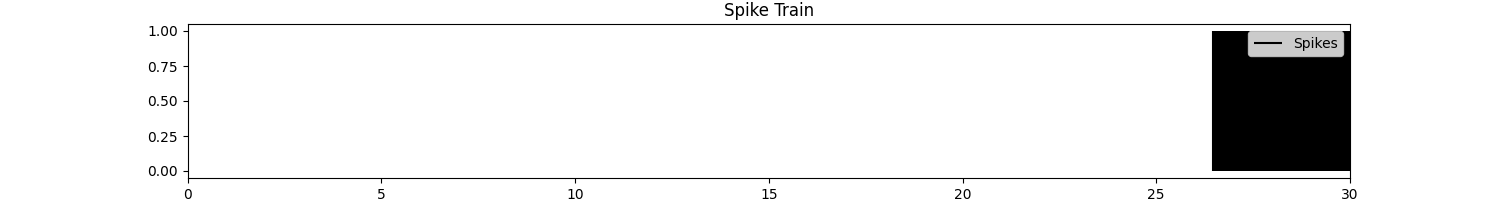

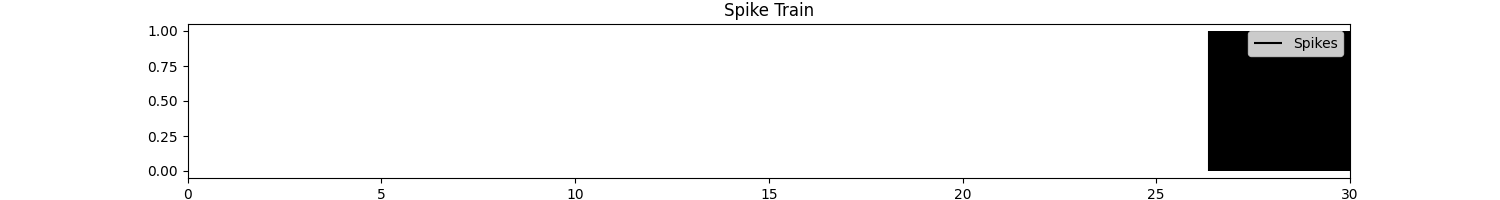

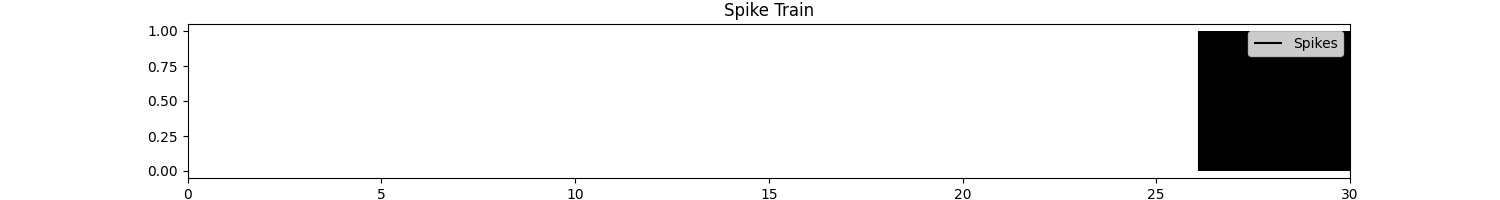

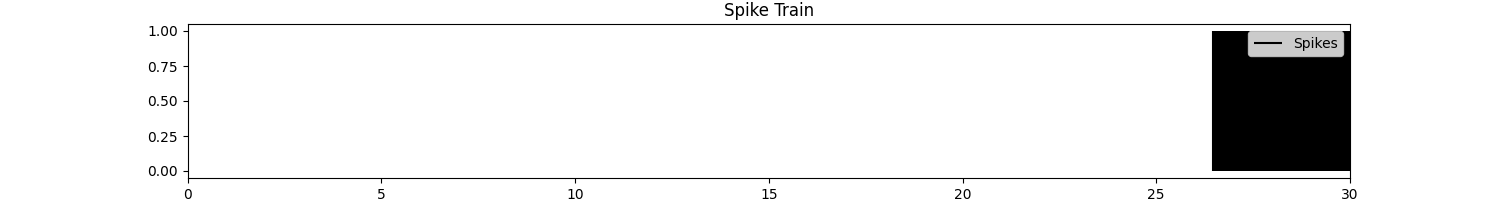

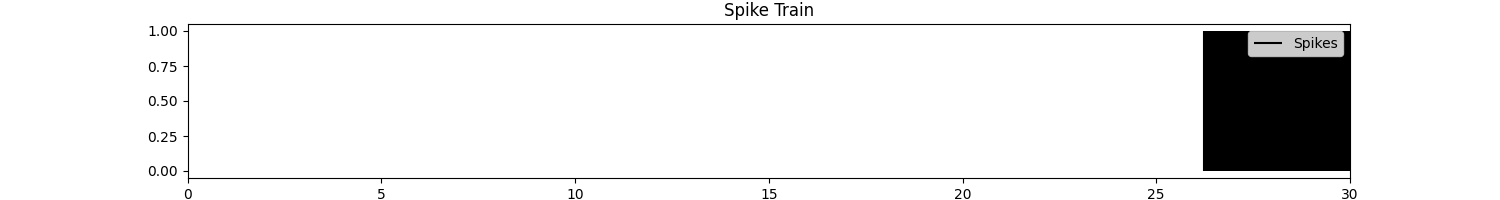

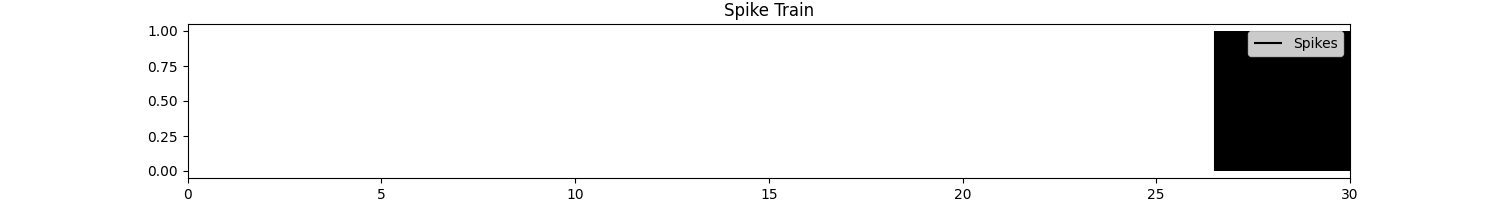

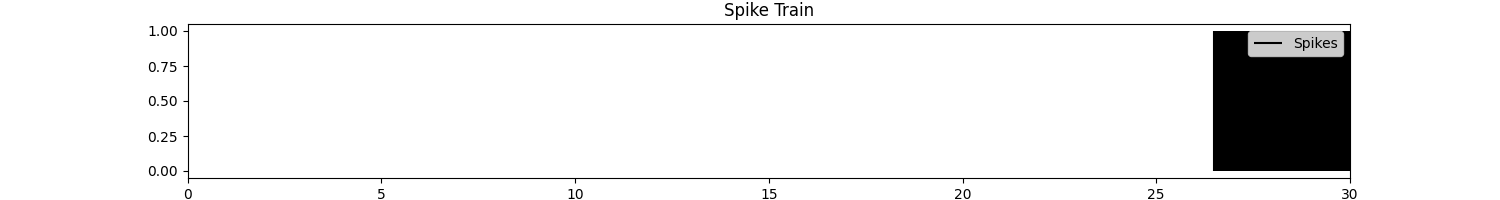

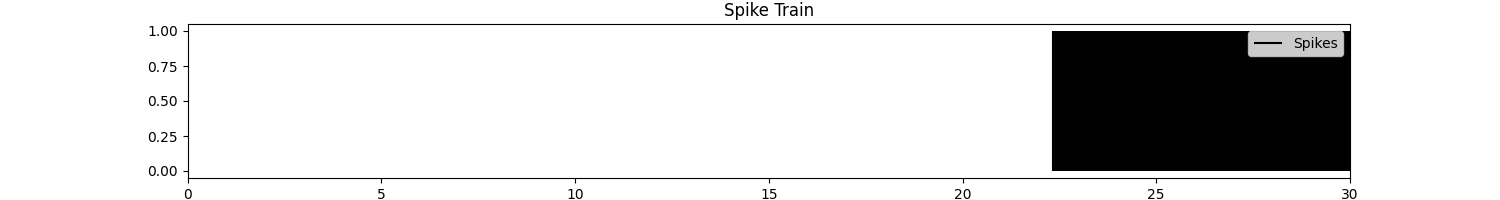

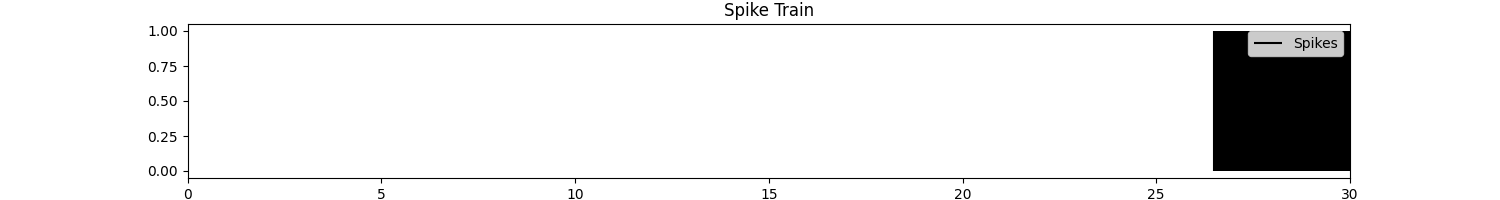

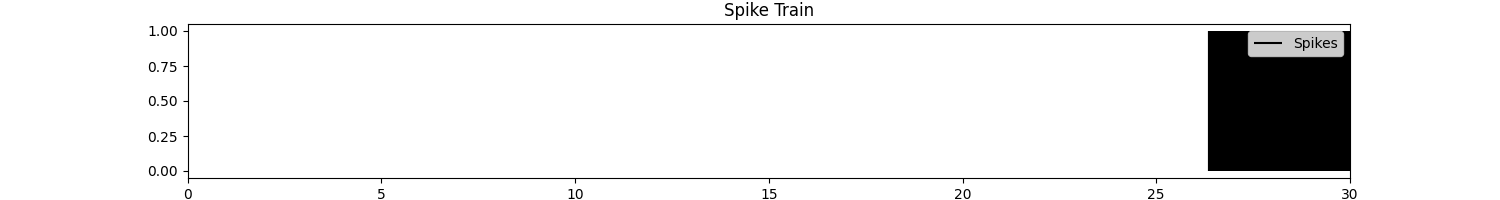

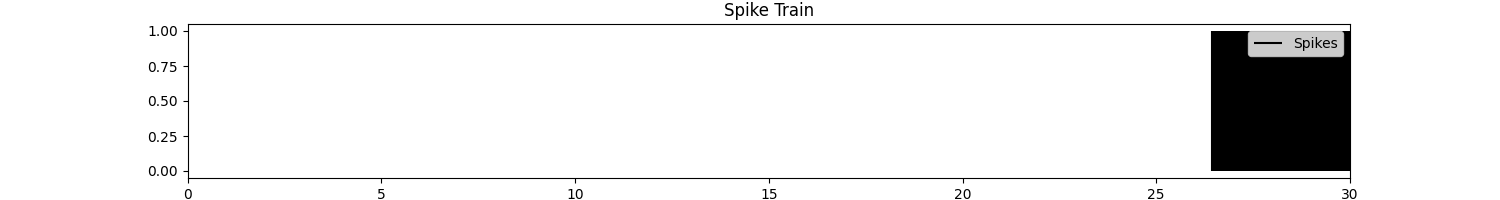

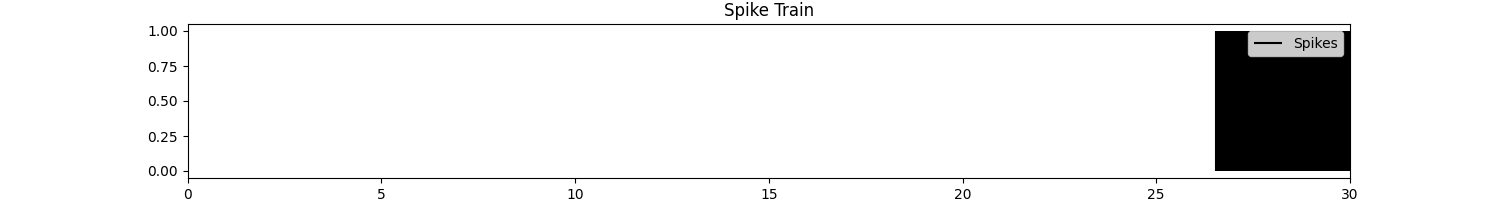

In [20]:
for list in MUPulsesB:
    plt.figure(figsize=(15, 2))
    time_interval_indices = np.divide(list["SpikeTrain"], 4096)
    plt.vlines(time_interval_indices, 0,1, color='black', linestyle='solid', label='Spikes')
    # Customize the plot as needed
    plt.xlim([0,30])
    plt.xlabel('Time in S')
    plt.title('Spike Train')
    plt.legend()
    plt.show()

In [11]:
print(np.divide(list2,2))

[46220.5 46267.  46314.5 46365.  46410.5 46462.  46516.5 46564.  46611.
 46659.5 46702.5 46751.5 46801.  46856.  46901.5 46947.5 46998.  47045.5
 47114.5 47187.5 47233.5 47285.5 47334.5 47376.5 47417.5 47463.  47512.
 47553.  47596.5 47646.  47702.5 47773.5 47825.  47872.  47927.5 47968.5
 48009.5 48063.  48114.  48168.  48225.5 48273.  48322.  48364.5 48415.5
 48475.  48520.5 48568.  48620.  48668.5 48725.  48769.5 48829.  48876.
 48933.5 48975.5 49025.5 49073.5 49123.5 49165.  49206.  49274.5 49323.5
 49376.5 49429.5 49481.5 49527.  49569.  49613.  49663.  49708.  49750.5
 49798.5 49845.5 49892.  49945.5 49986.5 50039.  50094.  50167.5 50212.
 50268.  50309.5 50365.5 50413.  50462.  50515.  50560.5 50614.5 50672.5
 50716.5 50767.5 50811.  50856.  50910.  50964.5 51014.5 51062.5 51105.
 51156.  51207.5 51269.5 51328.  51376.5 51429.  51475.5 51519.  51577.5
 51623.  51676.  51719.  51787.  51842.  51884.  51936.  51977.  52018.
 52074.5 52115.5 52158.  52202.5 52244.  52290.5 52334.  

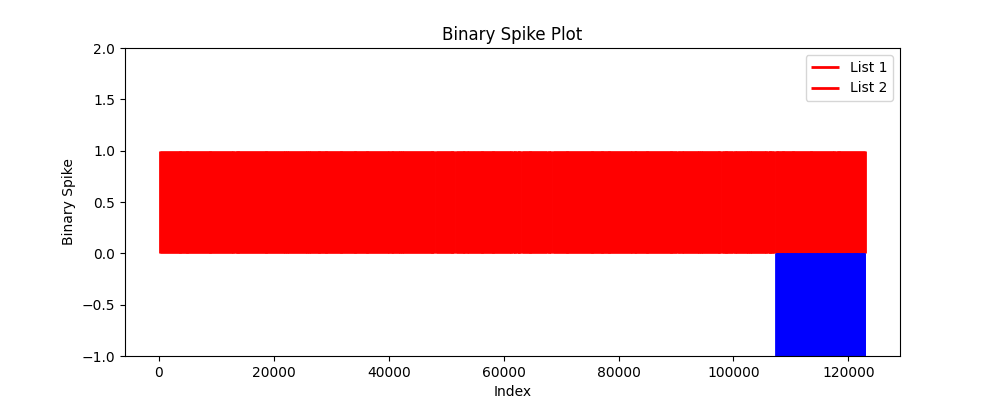

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[30][0]
list2 = MUPulsesB[12]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

In [ ]:
sns.heatmap(roa_matrix, cmap='coolwarm')

<Axes: title={'center': 'Binary Spike Plot'}>

In [ ]:
sns.heatmap(dup_matrix, cmap='coolwarm')

<Axes: title={'center': 'Binary Spike Plot'}>